In [56]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt

from datetime import datetime

# yahoo Finance API library (useful?)
import yfinance as yf

import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense, LSTM

from pandas_datareader import data as pdr
yf.pdr_override()

In [57]:
stock = 'TSLA'

end = datetime.now()
start = datetime(end.year - 3, end.month, end.day)

In [58]:
globals()[stock] = yf.download(stock, start, end)
df_tsla = globals()[stock]

[*********************100%%**********************]  1 of 1 completed


## Data Cleaning

In [59]:
df_tsla.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-05-03,234.600006,235.333328,226.833328,228.300003,228.300003,81129300
2021-05-04,226.313339,227.816666,219.233337,224.533340,224.533340,89217900
2021-05-05,227.020004,228.433334,222.446671,223.646667,223.646667,65705700
2021-05-06,226.919998,227.006668,216.666672,221.179993,221.179993,83353800
2021-05-07,221.933334,230.000000,220.073334,224.123337,224.123337,70407600


In [60]:
df_tsla.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-04-26,168.850006,172.119995,166.369995,168.289993,168.289993,109815700
2024-04-29,188.419998,198.869995,184.539993,194.050003,194.050003,243869700
2024-04-30,186.979996,190.949997,182.839996,183.279999,183.279999,127031800
2024-05-01,182.000000,185.860001,179.009995,179.990005,179.990005,92829700
2024-05-02,182.860001,184.600006,176.020004,180.009995,180.009995,88956200


In [61]:
df_tsla.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 756 entries, 2021-05-03 to 2024-05-02
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       756 non-null    float64
 1   High       756 non-null    float64
 2   Low        756 non-null    float64
 3   Close      756 non-null    float64
 4   Adj Close  756 non-null    float64
 5   Volume     756 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 41.3 KB


In [62]:
df_tsla.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

## Data Analysis

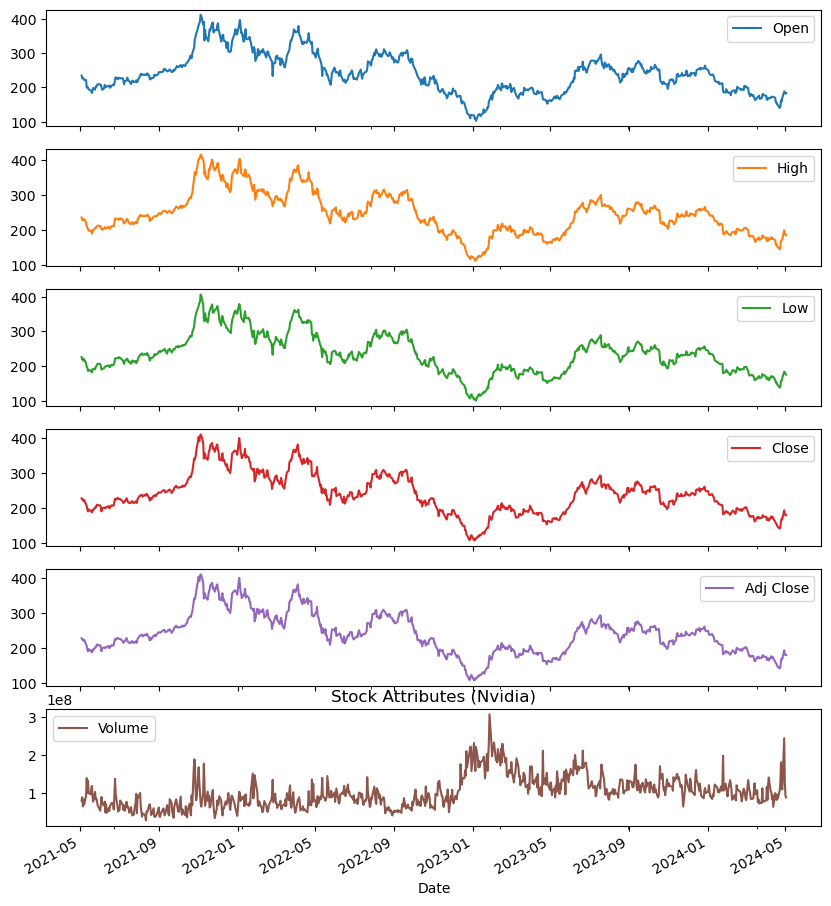

In [63]:
df_tsla.plot(subplots = True, figsize=(10,12))
plt.title("Stock Attributes (Nvidia)")
plt.show()

In [64]:
fig = px.line(df_tsla, y=['Open', 'Close', 'High', 'Low', 'Adj Close'], title = 'Date vs Stock Prices')
fig.show()

In [65]:
fig = px.line(df_tsla, y=['Volume'], title = 'Date vs Stock Prices')
fig.show()

In [66]:
# tesla Candlestick Chart

fig = go.Figure(data=[go.Candlestick(x=df_tsla.index, open=df_tsla['Open'], high=df_tsla['High'], low=df_tsla['Low'], close=df_tsla['Close'])])

fig.update_layout(title='Tesla Stock Price Candlestick Chart', xaxis_title='Date', yaxis_title='Stock Price (USD)')
fig.show()

## Calculation of MA

Text(0.5, 1.0, 'Tesla Moving Averages')

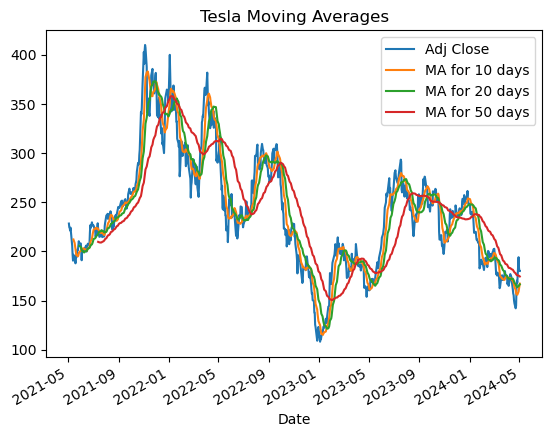

In [67]:
ma_day = [10,20,50]

for ma in ma_day:
    column_name = f"MA for {ma} days"
    df_tsla[column_name] = df_tsla['Adj Close'].rolling(ma).mean()

df_tsla[['Adj Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot()
plt.title("Tesla Moving Averages")

Text(0.5, 1.0, 'Tesla Daily Return')

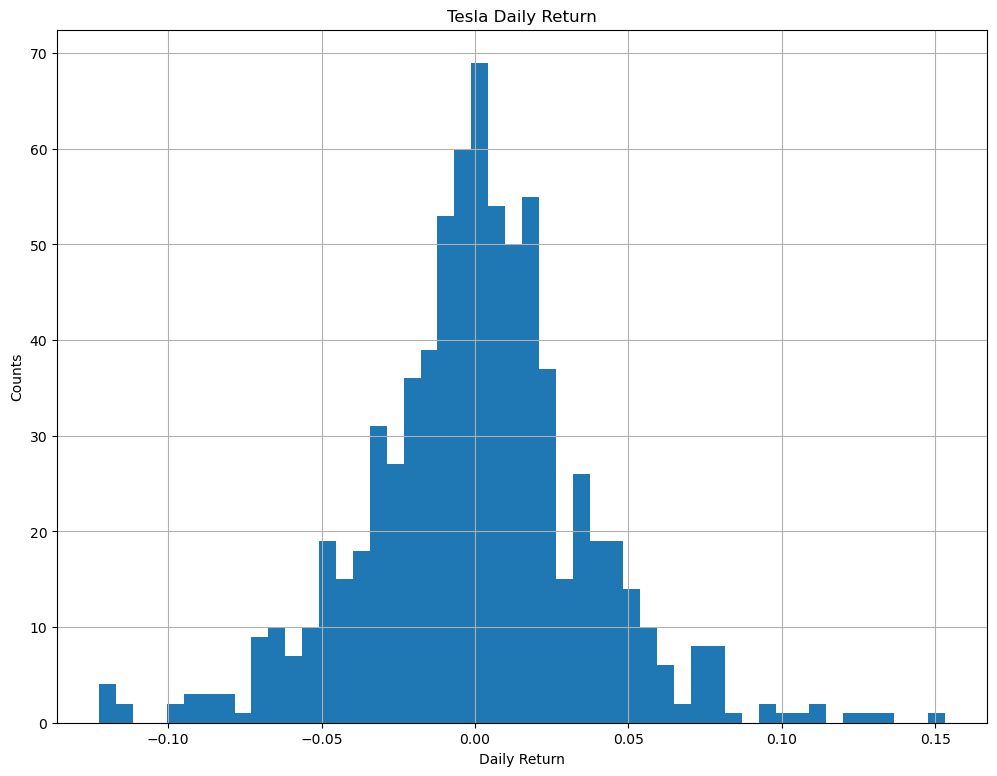

In [68]:
df_tsla['Daily Return'] = df_tsla['Adj Close'].pct_change()

plt.figure(figsize=(12,9))

df_tsla['Daily Return'].hist(bins=50)
plt.xlabel('Daily Return')
plt.ylabel('Counts')
plt.title('Tesla Daily Return')

Daily Return is the percentage of change in a stock's price from one trading day to the next. From what can be seen, the stock's price tends to fluctuate in a narrow range on a daily basis, forming a unimodal distribution. Increasing and decreasing approximately 5% but there is a noticeable percentage of change ocurring between -10% and -5%.

## Risk

In [69]:
closing_df = pdr.get_data_yahoo(stock, start=start, end=end)['Adj Close']
tech_rets = closing_df.pct_change()

[*********************100%%**********************]  1 of 1 completed


Text(50, 50, 'TSLA')

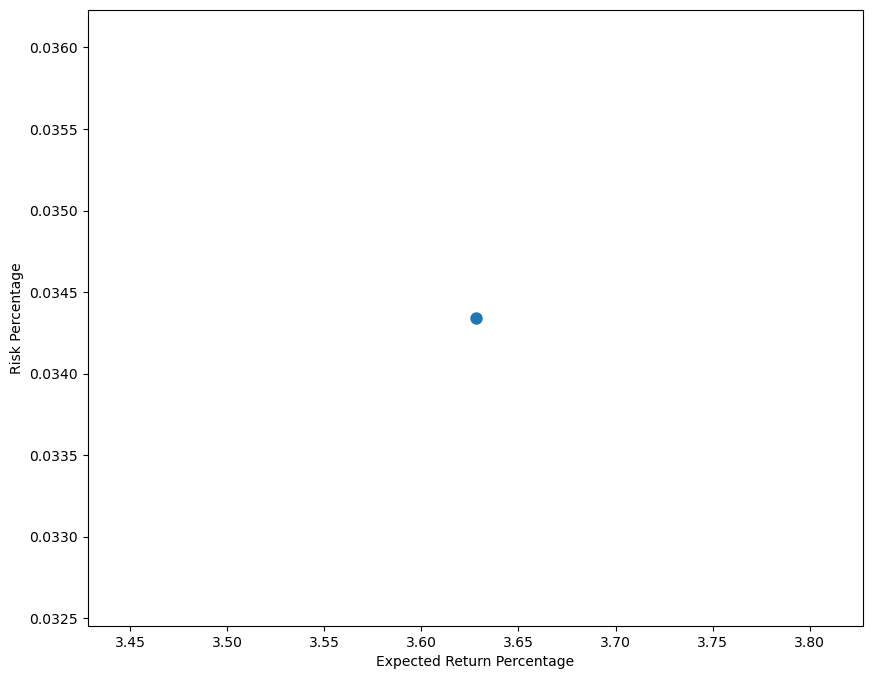

In [70]:
rets = tech_rets.dropna()

area = np.pi * 20

return_lvl = rets.mean()
return_lvl = return_lvl * 100

risk = rets.std()
risk = risk * 100

plt.figure(figsize=(10,8))
plt.scatter(risk, return_lvl, s=area)
plt.xlabel('Expected Return Percentage')
plt.ylabel('Risk Percentage')

plt.annotate(stock, xy=(rets.mean(), rets.std()), xytext=(50,50), textcoords='offset points', ha='right', va='bottom', arrowprops=dict(arrowstyle='-', color='blue'))

## Prediction Model

In [71]:
start = datetime(end.year - 5, end.month, end.day)
df_tsla = pdr.get_data_yahoo('TSLA', start=start, end=end)

df_tsla.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-05-03,16.257334,17.107332,16.232668,17.002001,17.002001,355602000
2019-05-06,16.667999,17.223333,16.566668,17.022667,17.022667,162508500
2019-05-07,17.120001,17.147333,16.340000,16.470667,16.470667,151971000
2019-05-08,16.462667,16.706667,16.280001,16.322666,16.322666,92646000
2019-05-09,16.133333,16.245333,15.796000,16.132000,16.132000,100671000


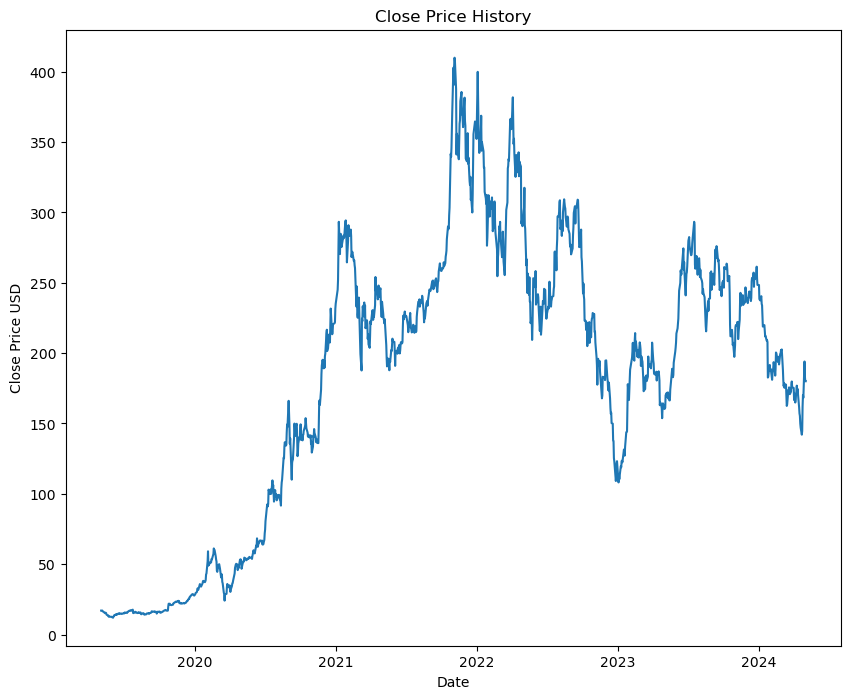

In [72]:
plt.figure(figsize=(10,8))
plt.title('Close Price History')
plt.plot(df_tsla['Close'])
plt.xlabel('Date')
plt.ylabel('Close Price USD')
plt.show()

In [73]:
window_size = 60

# Define the LSTM model
model = Sequential([
    LSTM(units=50, activation='relu', input_shape=(window_size, 1)),
    Dense(units=1)
])

# Compile the model
model.compile(optimizer='adam', loss='mse')

In [74]:
X = df_tsla[['High', 'Low', 'Open']]  # Features
y = df_tsla['Close']  # Target variable

# Create new dataframe with only 'Close' column
data = df_tsla.filter(['Close'])
# convert dataframe to numpy array
dataset = data.values
# get number of rows to train the model on
training_data_len = int(np.ceil(len(dataset) * .95))

scaler = MinMaxScaler()
scaled_prices = scaler.fit_transform(dataset)

# Create sequences
X, y = [], []
for i in range(len(scaled_prices) - window_size):
    X.append(scaled_prices[i:i+window_size])
    y.append(scaled_prices[i+window_size])

X, y = np.array(X), np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/100
30/30 [==============================] - 2s 25ms/step - loss: 0.1119 - val_loss: 0.0042
Epoch 2/100
30/30 [==============================] - 1s 18ms/step - loss: 0.0043 - val_loss: 0.0027
Epoch 3/100
30/30 [==============================] - 1s 17ms/step - loss: 0.0023 - val_loss: 0.0021
Epoch 4/100
30/30 [==============================] - 1s 17ms/step - loss: 0.0018 - val_loss: 0.0017
Epoch 5/100
30/30 [==============================] - 1s 18ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 6/100
30/30 [==============================] - 1s 17ms/step - loss: 0.0015 - val_loss: 0.0016
Epoch 7/100
30/30 [==============================] - 1s 18ms/step - loss: 0.0015 - val_loss: 0.0012
Epoch 8/100
30/30 [==============================] - 1s 18ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 9/100
30/30 [==============================] - 1s 18ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 10/100
30/30 [==============================] - 1s 18ms/step - loss: 0.0013 - val_loss: 0.0012

In [75]:
y_pred = model.predict(X_test)

8/8 [==============================] - 0s 6ms/step


In [76]:
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
loss = model.evaluate(X_test, y_test)

print('Test Loss:', loss)
print('Mean Squared Error:', mse)
print('Root Mean Squared Error:', rmse)
print('R-squared (R2) Score:', r2)


8/8 [==============================] - 0s 6ms/step - loss: 5.1600e-04
Test Loss: 0.0005159983411431313
Mean Squared Error: 0.0005159983272261081
Root Mean Squared Error: 0.022715596563289024
R-squared (R2) Score: 0.9906807352819215


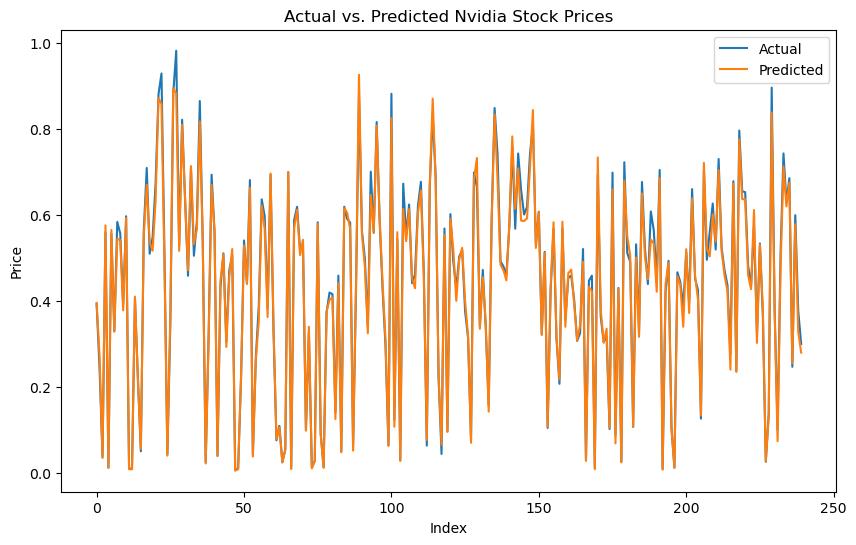

In [77]:
# Plot actual vs. predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.xlabel('Index')
plt.ylabel('Price')
plt.title('Actual vs. Predicted')
plt.legend()
plt.show()

In [78]:
# creating a new dataset to analyze within 60 days
test_data = scaled_prices[training_data_len - 60: , :]
test_set = []
for i in range(60, len(test_data)):
    test_set.append(test_data[i-60:i, 0])

# Convert the data to a numpy array
test_set = np.array(test_set)

# Reshape the data
test_set = np.reshape(test_set, (test_set.shape[0], test_set.shape[1], 1 ))

prediction = model.predict(test_set)
scaled_pred = scaler.inverse_transform(prediction)

# Plot the data
valid = data[training_data_len:]
valid['Predictions'] = scaled_pred

2/2 [==============================] - 0s 8ms/step


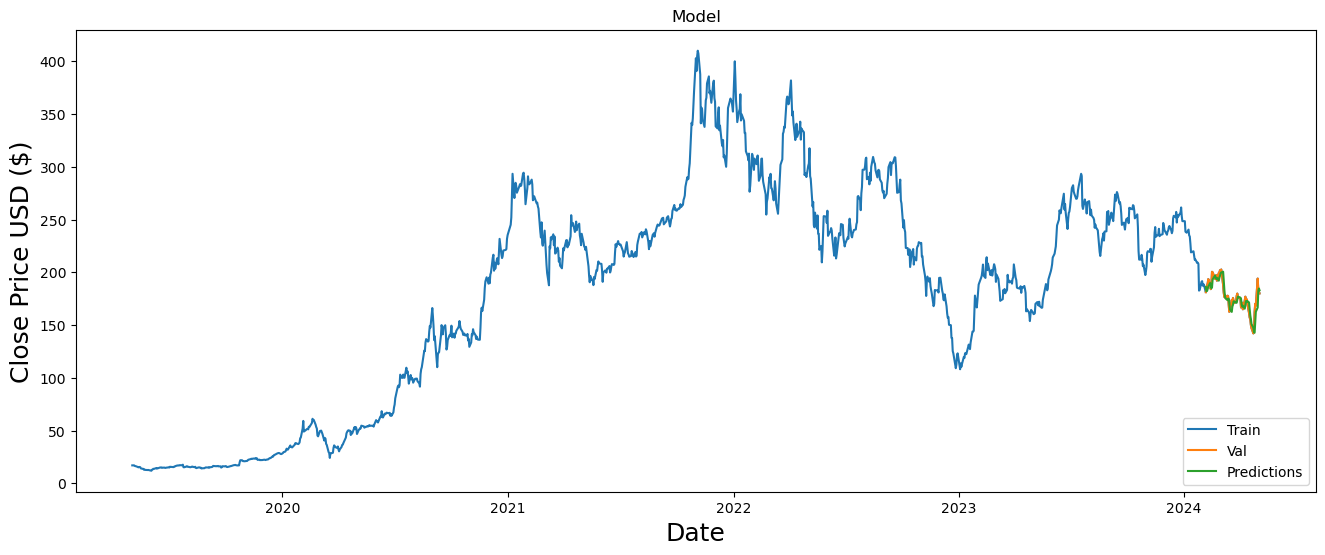

In [79]:
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(df_tsla['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

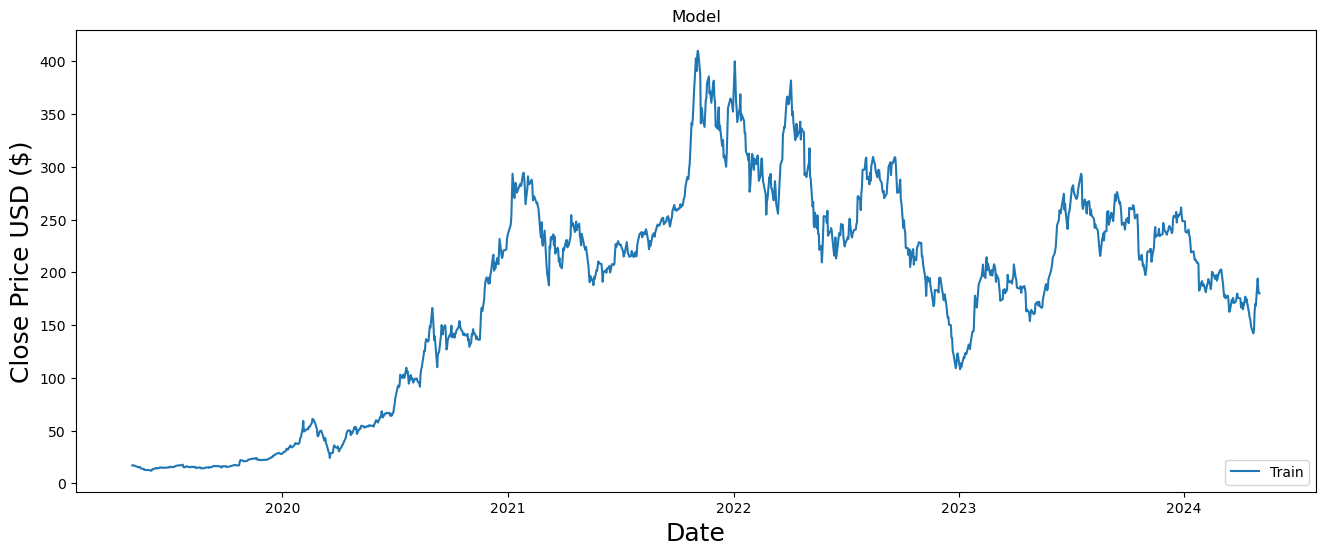

In [80]:
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(df_tsla['Close'])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [81]:
valid

,Close,Predictions
Date,,
2024-02-05,181.059998,186.171982
2024-02-06,185.100006,182.039261
2024-02-07,187.580002,182.281372
2024-02-08,189.559998,184.172684
2024-02-09,193.570007,186.404404
...,...,...
2024-04-26,168.289993,162.506790
2024-04-29,194.050003,166.636398
2024-04-30,183.279999,182.301437


## Prediction

In [82]:
last_60_days = scaled_prices[-60:]

x_predict = np.reshape(last_60_days, (1,60,1))

predicted_value = model.predict(x_predict)

predicted_decimal = scaler.inverse_transform(predicted_value)

print("Predicted Decimal Value for the Next Day:", predicted_decimal[0][0])

1/1 [==============================] - 0s 22ms/step
Predicted Decimal Value for the Next Day: 181.18326


In [83]:
future_days = 5

last_60_days = scaled_prices[-60:]

x_predict = np.reshape(last_60_days, (1,60,1))

predicted_values = []
for _ in range(future_days):
    # Predict the next day
    predicted_value = model.predict(x_predict)
    predicted_decimal = scaler.inverse_transform(predicted_value)
    
    # Store the predicted value
    predicted_values.append(predicted_decimal[0][0])
    
    # Shift the input data by one day for the next prediction
    x_predict = np.roll(x_predict, -1)
    x_predict[0, -1, 0] = predicted_value  # Replace the last value with the predicted value

print("Predicted Decimal Values for the Next", future_days, "Days:", predicted_values)

1/1 [==============================] - 0s 22ms/step
Predicted Decimal Values for the Next 5 Days: [181.18326, 180.57365, 179.78653, 178.86273, 177.85414]
